# Benchmark Notebook
This notebook shows a quick python interface usage of the package `sr-metric`.

In [1]:
import sys
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import tifffile
import mrcfile
import numpy as np
from matplotlib_scalebar.scalebar import ScaleBar
import pandas as pd

# Add the relative path to ../SRmetric
sys.path.append(os.path.abspath(os.path.join('..')))

from SRmetric.metric import *

## Load Image

In [2]:
WF_PATH = "../data/tirf-sim/HighNA/RBLCell6_pc50pw50_NA160_cyc3_20241031_130414_WF.tif"
SR_PATH = "../data/tirf-sim/HighNA/RBLCell6_pc50pw50_NA160_cyc3.mrc"

In [3]:
def im_read(path):
    file_name, file_extension = os.path.splitext(path)

    if file_extension in [".tif",".tiff"]:
        return tifffile.imread(path)
    elif file_extension == ".mrc":
        with mrcfile.open(path, permissive=True) as mrc:
            # Access the data
            mrc_data = mrc.data
            print("voxel size:",mrc.voxel_size)
        return np.transpose(mrc_data,axes=(0,2,1))
    else:
        raise NotImplementedError("File type {} not supported".format(file_extension))

In [4]:
wf_img = im_read(WF_PATH)
sr_img = im_read(SR_PATH)

voxel size: (0.03065, 0.03065, 0.05)


/home/jackyko/mambaforge/envs/sr-metric/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:206: RuntimeWarning: Map ID string not found - not an MRC file, or file is corrupt
  warnings.warn(msg, RuntimeWarning)
/home/jackyko/mambaforge/envs/sr-metric/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:216: RuntimeWarning: Unrecognised machine stamp: 0x00 0x00 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)
/home/jackyko/mambaforge/envs/sr-metric/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:238: RuntimeWarning: Machine stamp '0x00 0x00 0x00 0x00' does not match the apparent byte order '>'
  warnings.warn(msg.format(pretty_machst, header.mode.dtype.byteorder),


In [5]:
# Define a custom colormap: cyan to white to hot
colors = [
    (0.0, "black"),   # Start with cyan
    (0.7, "cyan"),   # Start with cyan
    (1.0, "white")     # End with hot (red at high values)
]
cyan_hot_cmap = LinearSegmentedColormap.from_list("cyan_hot", colors)

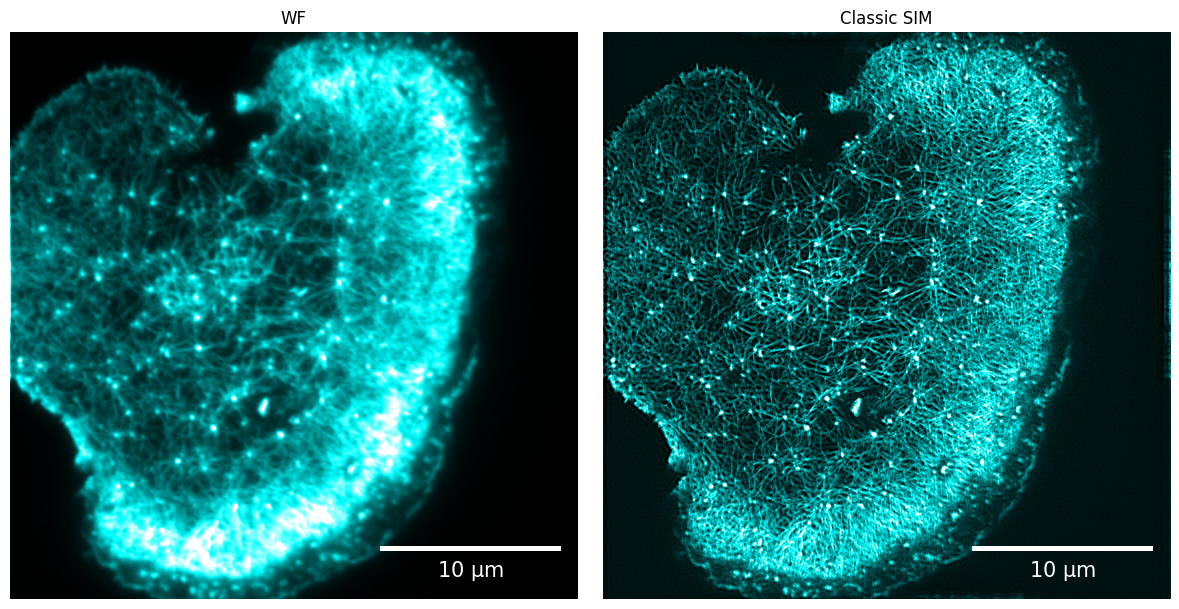

In [6]:
fig, axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow(wf_img,vmin=np.percentile(wf_img,1),vmax=np.percentile(wf_img,99.5),cmap=cyan_hot_cmap)
axs[0].set_axis_off()
axs[0].set_title("WF")
# Add a scale bar
scalebar = ScaleBar(0.03065, 
                    units="um",
                    location="lower right",
                    color="white",
                    # length_fraction=0.4,
                    label_loc="top",
                    width_fraction=0.01,
                    fixed_value=10,
                    border_pad=1,
                    # pad=0.2,
                    frameon=False,
                    font_properties={"size":15},
                    ) 
axs[0].add_artist(scalebar)

axs[1].imshow(sr_img[0],vmin=np.percentile(sr_img[0],1),vmax=np.percentile(sr_img[0],99.5),cmap=cyan_hot_cmap)
axs[1].set_axis_off()
axs[1].set_title("Classic SIM")
# Add a scale bar
scalebar = ScaleBar(0.03065, 
                    units="um",
                    location="lower right",
                    color="white",
                    # length_fraction=0.4,
                    label_loc="top",
                    width_fraction=0.01,
                    fixed_value=10,
                    border_pad=1,
                    # pad=0.2,
                    frameon=False,
                    font_properties={"size":15},
                    ) 
axs[1].add_artist(scalebar)

fig.tight_layout()

## Performance Benchmark

In [11]:
class SRMetric:
    """
    A Python class object to compute 

    Attributes:
    -----------
    img1 : numpy.array
        2D numpy array of pre-processed image
    img2 : numpy.array
        2D numpy array of processed image
    """
    def __init__(self, 
                 img1,
                 img2,
                 verbose = True,
                 ):
        self.img1 = img1
        self.img2 = img2
        self.verbose = verbose

    def compute_nMSE(self):
        nMSE = 0
        return nMSE

    def compute_PSNR(self):
        psnr = 0
        return psnr
    
    def compute_SSIM(self):
        ssim = 0
        return ssim

    def compute_PCC(self):
        pcc = 0
        return pcc
    
    def compute_mutual_info(self):
        mi = 0
        return mi

    def compute_metric(self):
        res = {
            "nMSE": self.compute_nMSE(),
            "PSNR": self.compute_PSNR(),
            "SSIM": self.compute_SSIM(),
            "PCC": self.compute_PCC(),
            "MI": self.compute_mutual_info(),
            }
        
        res = pd.Series(res)

        if self.verbose:
            print("Image Relative Metric:")
            print(res)

        return res
    
    def compute_resolution_map():
        raise NotImplementedError("Function not implemented")
        return
    
srmetric = SRMetric(wf_img,sr_img[0])
metric = srmetric.compute_metric()

Image Relative Metric:
nMSE    0
PSNR    0
SSIM    0
PCC     0
MI      0
dtype: int64
